### Employee Attrition using **CatBoost**

* L.S, ottobre 2021
* gestione delle **feature categoriche**
* importanza del **Learning rate**
* gestione dataset imbalance tramite **class weights**
* integrazione con **MLFLow**
* salvataggio del modello nel **Model Catalog**

In [1]:
import pandas as pd
import numpy as np

# for reading data from Object Storage
import ocifs
from ads import set_auth

# usero' catboost
import catboost as cat

# per la confusion matrix ed altre metriche uso sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

# grafici
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

In [2]:
# this way we enable access to Object Storage
set_auth(auth='resource_principal')

In [3]:
# utility function and globals
# GLOBALS
FIGSIZE = (9, 6)

SEED = 42

# additional print
DEBUG = 0

#
# easy plot of the confusion matrix
#
def plot_cm(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();

    
#
# Compute metrics
#
def compute_auc(model, x_test, y_test):
    y_pred = model.predict_proba(x_test)
    y_pred = y_pred[:, 1]
    auc = round(roc_auc_score(y_test, y_pred), 4)
    
    return auc

def compute_prec_rec(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    
    rec = round(recall_score(y_test, y_pred_labels), 4)
    prec = round(precision_score(y_test, y_pred_labels), 4)
    
    return prec, rec

def compute_accuracy(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred_labels)
    
    return round(acc, 3)

def set_as_categorical(dataf, cat_columns):
    for c in cat_columns:
        if DEBUG:
            print('Setting:', c)
        dataf[c] = dataf[c].astype('category')
            
    return dataf

#
# my split in train, test set
#
def my_train_test_split(df, frac):
    # frac: the fraction used for train
    # df: the dataframe
    
    # shuffle before split
    df = df.sample(frac=1., random_state=SEED)

    # FRAC = 0.90
    tot_rec = df.shape[0]
    NUM_TRAIN = int(frac*tot_rec)
    NUM_TEST = tot_rec - NUM_TRAIN

    data_train = df[:NUM_TRAIN]
    data_test = df[NUM_TRAIN:]

    print()
    print('Numero totale di campioni:', tot_rec)
    print('Numero di campioni nel TRAIN SET:', data_train.shape[0])
    print('Numero di campioni nel TEST SET:', data_test.shape[0])
    
    return data_train, data_test

# read the csv from Object storage and return a pandas df
def read_from_object_storage(prefix, file_name):
    # get access to OSS as an fs
    # config={} assume resource_principal auth
    fs = ocifs.OCIFileSystem(config={})
    
    FILE_PATH = prefix + file_name
    
    # reading data from Object Storage
    with fs.open(FILE_PATH, 'rb') as f:
        df = pd.read_csv(f)
    
    return df

In [4]:
# integration with mlflow
#set the tracking uri to log runs on a tracking server
TRACKING_URI = "http://150.230.146.100:5000/"

mlflow.set_tracking_uri(TRACKING_URI)

#create an experiment to log runs into it.
EXP_NAME = "Catboost exp14"

mlflow.set_experiment(EXP_NAME)

# start the first run
mlflow.start_run()

INFO: 'Catboost exp14' does not exist. Creating a new experiment


<ActiveRun: >

In [5]:
# input data from file in Object Storage
PREFIX = "oci://data_input@fr95jjtqbdhh/"
FILE_NAME = "orcl_attrition.csv"

# see in functions above
data_orig = read_from_object_storage(prefix=PREFIX, file_name=FILE_NAME)

# some columns are not needed. This is the list of columns that will be used
my_columns = ['Age', 'Attrition', 'EnvironmentSatisfaction', 'MaritalStatus', 'TravelForWork', 'SalaryLevel', 'JobFunction', 'CommuteLength', 'EducationalLevel', 'EducationField', 'MonthlyIncome', 
              'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'WorkLifeBalance']

# dataset filtrato eliminando le colonne non necessarie
data = data_orig[my_columns]

data.head()

,Age,Attrition,EnvironmentSatisfaction,MaritalStatus,TravelForWork,SalaryLevel,JobFunction,CommuteLength,EducationalLevel,EducationField,MonthlyIncome,OverTime,StockOptionLevel,TrainingTimesLastYear,YearsSinceLastPromotion,WorkLifeBalance
0,42,Yes,2,Single,infrequent,5054,Product Management,2,L2,Life Sciences,5993,Yes,0,0,0,1
1,50,No,3,Married,often,1278,Software Developer,9,L1,Life Sciences,5130,No,1,3,1,3
2,38,Yes,4,Single,infrequent,6296,Software Developer,3,L2,Other,2090,Yes,0,3,0,3
3,34,No,4,Married,often,6384,Software Developer,4,L4,Life Sciences,2909,Yes,0,3,3,3
4,28,No,1,Married,infrequent,2710,Software Developer,3,L1,Medical,3468,No,1,3,2,3


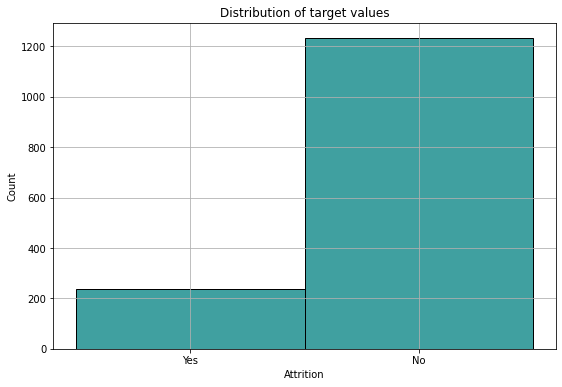

In [6]:
# distribution of target
plt.figure(figsize=FIGSIZE)
plt.title('Distribution of target values')
plt.grid(True)
sns.histplot(data['Attrition']);

In [7]:
# compute the ratio, for class weights
condition = data['Attrition'] == 'Yes'

n_pos = data.loc[condition].shape[0]
n_neg = data.shape[0] - n_pos
ratio = n_neg/n_pos

print('Il rapporto negativi/positivi è:', round(ratio, 2))

Il rapporto negativi/positivi è: 5.2


In [8]:
# tipologie di features e colonne
TARGET = 'Attrition'

# automatizziamo !!!
all_columns = sorted(data.columns)
features = sorted(list(set(all_columns) - set([TARGET])))

# per decidere, guarda statistiche dal Notebook 1
cat_columns = sorted(['Age', 'CommuteLength','EnvironmentSatisfaction','MaritalStatus', 'TravelForWork', 'JobFunction', 
                      'EducationalLevel', 'EducationField', 'OverTime', 
                      'StockOptionLevel', 'TrainingTimesLastYear',
                      'YearsSinceLastPromotion', 'WorkLifeBalance'])



# colonne numeriche, continue (tutte le altre)
num_columns = sorted(list(set(all_columns) - set(cat_columns) - set([TARGET])))

print('Colonna Target:', TARGET)
print()
print('Tutte le features:', features, len(features))
print()
print('Colonne categorical:', cat_columns, len(cat_columns))
print()
print('Colonne numeriche:', num_columns, len(num_columns))


# split TRAIN, TEST
# shuffle prima dello split TRAIN, TEST
FRAC = 0.90

data_train, data_test = my_train_test_split(data, frac=FRAC)

Colonna Target: Attrition

Tutte le features: ['Age', 'CommuteLength', 'EducationField', 'EducationalLevel', 'EnvironmentSatisfaction', 'JobFunction', 'MaritalStatus', 'MonthlyIncome', 'OverTime', 'SalaryLevel', 'StockOptionLevel', 'TrainingTimesLastYear', 'TravelForWork', 'WorkLifeBalance', 'YearsSinceLastPromotion'] 15

Colonne categorical: ['Age', 'CommuteLength', 'EducationField', 'EducationalLevel', 'EnvironmentSatisfaction', 'JobFunction', 'MaritalStatus', 'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear', 'TravelForWork', 'WorkLifeBalance', 'YearsSinceLastPromotion'] 13

Colonne numeriche: ['MonthlyIncome', 'SalaryLevel'] 2

Numero totale di campioni: 1470
Numero di campioni nel TRAIN SET: 1323
Numero di campioni nel TEST SET: 147


In [9]:
# separo X ed y
x_train = data_train[features]
y_train = data_train[TARGET]

x_test = data_test[features]
y_test = data_test[TARGET]

# encode labels as 0, 1
le = LabelEncoder()

# fit the encoder
le.fit(y_train.values)

# encode train and test
y_train = le.transform(y_train.values)
y_test = le.transform(y_test.values)

# cat boost want indexes
cat_columns_idxs = [i for i, col in enumerate(x_train.columns) if col in cat_columns]

### First run, without class weights

In [10]:
%%time
# First: try without addressing data imbalance

params = {'iterations':900,
          'learning_rate':0.005,
          'depth':10
         }

model = cat.CatBoostClassifier()
model.set_params(**params)

# added for mlflow tracking 
mlflow.log_params(params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=False, early_stopping_rounds=30)

CPU times: user 2min 31s, sys: 29.8 s, total: 3min
Wall time: 11.3 s


In [11]:
# compute and register results
auc = compute_auc(model, x_test, y_test)

print('AUC computed on the test set is:', auc)

prec, rec = compute_prec_rec(model, x_test, y_test)

print('precision and recall computed on the test set are:', 'prec:', prec, 'rec:', rec)

acc = compute_accuracy(model, x_test, y_test)

print('Accuracy on test set is:', acc)

# register metrics on mlflow and close run
test_metrics = {}

test_metrics['precision'] = prec
test_metrics['recall'] = rec
test_metrics['auc'] = auc
test_metrics['acc'] = acc

mlflow.log_metrics(test_metrics)

# end run on MLFlow
mlflow.end_run()

AUC computed on the test set is: 0.8207
precision and recall computed on the test set are: prec: 0.7143 rec: 0.1852
Accuracy on test set is: 0.837


### Second run, with class weights

In [12]:
%%time

# start second run
mlflow.start_run()

# to address data imbalance
class_weights = dict({0:1, 1:5.5})

params = {'iterations':900,
          'learning_rate':0.005,
          'depth':10,
          'class_weights':class_weights
         }

model = cat.CatBoostClassifier()
model.set_params(**params)

# added for mlflow tracking 
mlflow.log_params(params)

model.fit(x_train, y_train, cat_columns_idxs, verbose=False, early_stopping_rounds=30)

CPU times: user 2min 35s, sys: 30.9 s, total: 3min 6s
Wall time: 11.6 s


In [13]:
# compute and register results
auc = compute_auc(model, x_test, y_test)

print('AUC computed on the test set is:', auc)

prec, rec = compute_prec_rec(model, x_test, y_test)

print('precision and recall computed on the test set are:', 'prec:', prec, 'rec:', rec)

acc = compute_accuracy(model, x_test, y_test)

print('Accuracy on test set is:', acc)

# register metrics on mlflow and close run
test_metrics = {}

test_metrics['precision'] = prec
test_metrics['recall'] = rec
test_metrics['auc'] = auc
test_metrics['acc'] = acc

mlflow.log_metrics(test_metrics)

# end run on MLFlow
mlflow.end_run()

AUC computed on the test set is: 0.8022
precision and recall computed on the test set are: prec: 0.4839 rec: 0.5556
Accuracy on test set is: 0.81


### Evaluate confusion matrix on test set

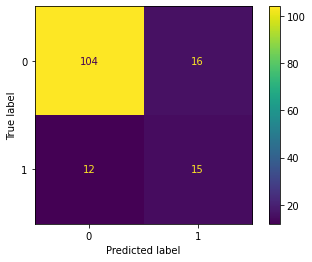

In [14]:
plot_cm(model, x_test, y_test)

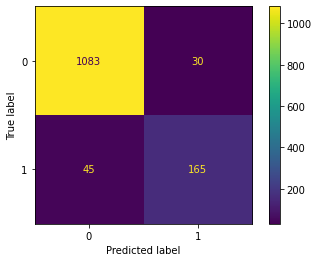

In [15]:
# c'è un certo overfitting...
plot_cm(model, x_train, y_train)

### Global explaination using feature importance

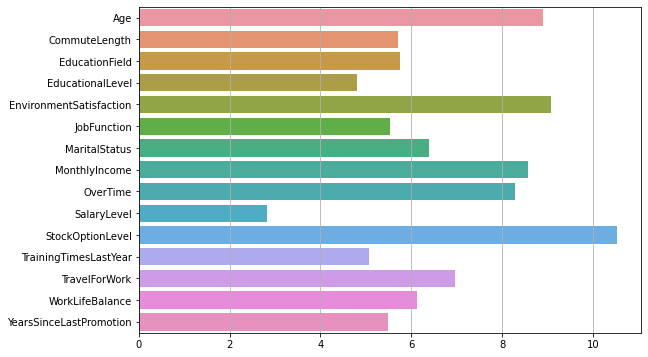

In [16]:
# eXplainability: Feature importance

plt.figure(figsize = FIGSIZE)
plt.grid(True)
sns.barplot(x = model.get_feature_importance(), y = features);

### Save the model to the Model Catalog

In [17]:
import os
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model

import json
import pickle

In [18]:
# 1. prepare artifacts directory

PATH_ARTEFACT = f"./model-files"

if not os.path.exists(PATH_ARTEFACT):
    os.mkdir(PATH_ARTEFACT)

In [19]:
# 2. serialize model

pickle.dump(model, open(PATH_ARTEFACT + '/model.pkl', 'wb'))

In [22]:
# 3. prepare deploy to Model Catalog
artifact = prepare_generic_model(PATH_ARTEFACT, function_artifacts=False, force_overwrite=True, data_science_env=True)

INFO:ADS:We give you the option to specify a different inference conda environment for model deployment purposes. By default it is assumed to be the same as the conda environment used to train the model. If you wish to specify a different environment for inference purposes, please assign the path of a published or data science conda environment to the optional parameter `inference_conda_env`. 


In [23]:
# 4. Saving the model artifact to the model catalog.
catalog_entry = artifact.save(display_name='model-catboost12', description='A model for Employee Attrition using catboost')

ERROR:ads:ADS Exception
Traceback (most recent call last):
  File "/home/datascience/conda/mlgpuv1/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-06f01dafc400>", line 2, in <module>
    catalog_entry = artifact.save(display_name='model-catboost12', description='A model for Employee Attrition using catboost')
  File "/home/datascience/conda/mlgpuv1/lib/python3.6/site-packages/ads/common/model_artifact.py", line 385, in save
    training_code_info = self._training_code_info(ns, training_script_path, ignore_pending_changes)
  File "/home/datascience/conda/mlgpuv1/lib/python3.6/site-packages/ads/common/model_artifact.py", line 434, in _training_code_info
    self._assert_path_not_dirty(self.artifact_dir, repo, ignore_pending_changes)
  File "/home/datascience/conda/mlgpuv1/lib/python3.6/site-packages/ads/common/model_artifact.py", line 448, in _assert_path_not_dirty
    ra

ChangesNotCommitted: 
            File(s) at /home/datascience/catboost-employee-attrition/model-files are either dirty or untracked. 
            Please commit changes and then save the model, or set `ignore_pending_changes=True`.
        